<a href="https://colab.research.google.com/github/MartaCampagnoli/HateSpeechDetection/blob/main/Output%20Notebooks/Classification_Part1_MultiClass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#importing libraries
from gensim.models import Word2Vec
from google.colab import files
import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import string
from string import punctuation
import xgboost as xgb
import gensim.downloader
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
#personalized set of stopwords
stopwords = nltk.corpus.stopwords.words('english')
exceptions = ["no", "not" , "don't", "they", "them"]
stop = [word for word in stopwords if word not in exceptions]
#stemmer
stemmer = nltk.SnowballStemmer("english")

In [ ]:
#preprocessing function
def preprocess(text):
    text = ''.join([word for word in text])
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop]
    tokens = [stemmer.stem(w) for w in tokens]
    return ' '.join(tokens)

In [ ]:
uploaded = files.upload() #sixcat.csv

Saving sixcat.csv to sixcat.csv


In [ ]:
df = pd.read_csv(io.BytesIO(uploaded['sixcat.csv'])) #sixcat

In [ ]:
train, test = train_test_split(df ,test_size=0.30, random_state = 42)

In [ ]:
#setting training and test
X_train, X_test, y_train, y_test = train['text'], test['text'], train['target'], test['target']

In [ ]:
X_train = X_train.apply(preprocess)
X_test = X_test.apply(preprocess)

In [ ]:
#tf idf
tf_idf = TfidfVectorizer()
X_train_tf = tf_idf.fit_transform(X_train)
X_test_tf = tf_idf.transform(X_test)

In [ ]:
#for word2vec
sentences = [sentence.split() for sentence in X_train]

## XGBoost TFIDF

In [ ]:
model = xgb.XGBClassifier()
model.fit(X_train_tf, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

              precision    recall  f1-score   support

           0       0.80      0.92      0.86       590
           1       0.91      0.81      0.85       222
           2       0.92      0.83      0.87       334
           3       0.95      0.86      0.90       299
           4       0.84      0.77      0.80       217
           5       0.89      0.91      0.90       621

    accuracy                           0.87      2283
   macro avg       0.88      0.85      0.87      2283
weighted avg       0.88      0.87      0.87      2283



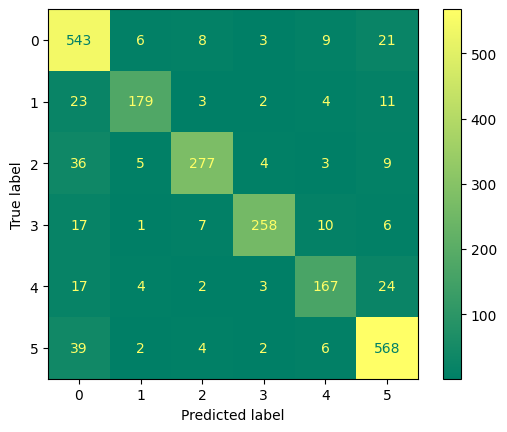

In [ ]:
y_pred = model.predict(X_test_tf)
print(metrics.classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap = 'summer')

## Logistic Regression TFIDF

In [ ]:
model = LogisticRegression(solver='sag', verbose = 1)
model.fit(X_train_tf, y_train)

convergence after 19 epochs took 0 seconds


LogisticRegression(solver='sag', verbose=1)

              precision    recall  f1-score   support

           0       0.82      0.94      0.87       590
           1       0.97      0.76      0.85       222
           2       0.96      0.79      0.87       334
           3       0.96      0.85      0.90       299
           4       0.93      0.73      0.82       217
           5       0.82      0.96      0.88       621

    accuracy                           0.87      2283
   macro avg       0.91      0.84      0.86      2283
weighted avg       0.88      0.87      0.87      2283



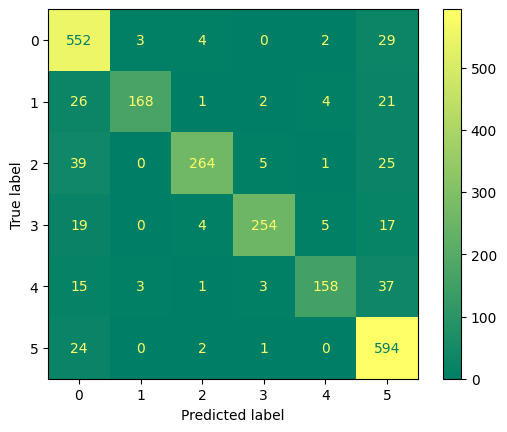

In [ ]:
y_pred = model.predict(X_test_tf)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap = 'summer')

## SGD TFIDF

              precision    recall  f1-score   support

           0       0.88      0.93      0.91       590
           1       0.95      0.83      0.88       222
           2       0.93      0.87      0.90       334
           3       0.95      0.90      0.92       299
           4       0.89      0.82      0.85       217
           5       0.87      0.94      0.91       621

    accuracy                           0.90      2283
   macro avg       0.91      0.88      0.90      2283
weighted avg       0.90      0.90      0.90      2283



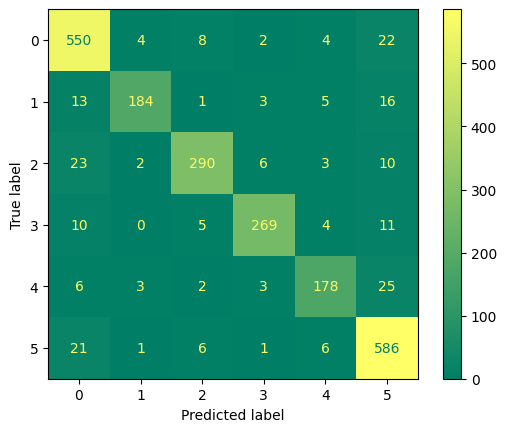

In [ ]:
#sgd
sgd = SGDClassifier(random_state=5)
sgd.fit(X_train_tf, y_train)
y_pred = sgd.predict(X_test_tf)

print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap = 'summer')

## Word2vec: training the embeddings

In [ ]:
w2v_model = Word2Vec(sentences, vector_size=300, window=2, min_count=10, workers=4)

In [ ]:
def vectorize(sentence):
    words = sentence.split()
    words_vecs = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if len(words_vecs) == 0:
        return np.zeros(300)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

In [ ]:
X_trainw2c = np.array([vectorize(sentence) for sentence in X_train])
X_testw2c = np.array([vectorize(sentence) for sentence in X_test])

In [ ]:
#xgboost
model = xgb.XGBClassifier()
model.fit(X_trainw2c, y_train)

              precision    recall  f1-score   support

           0       0.63      0.72      0.67       590
           1       0.62      0.31      0.41       222
           2       0.61      0.50      0.55       334
           3       0.69      0.66      0.68       299
           4       0.49      0.34      0.40       217
           5       0.67      0.84      0.74       621

    accuracy                           0.64      2283
   macro avg       0.62      0.56      0.58      2283
weighted avg       0.63      0.64      0.62      2283



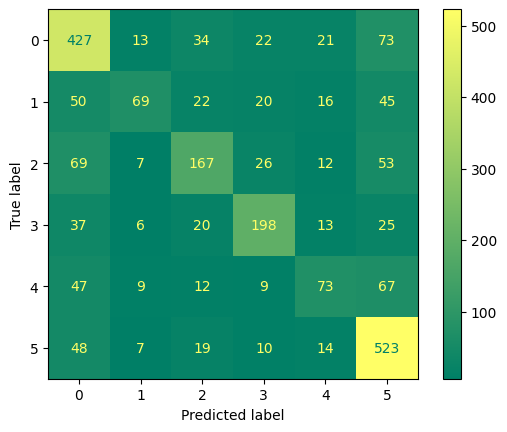

In [ ]:
y_pred = model.predict(X_testw2c)
print(metrics.classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap = 'summer')

              precision    recall  f1-score   support

           0       0.93      0.16      0.27       590
           1       0.00      0.00      0.00       222
           2       0.00      0.00      0.00       334
           3       0.16      0.97      0.28       299
           4       0.00      0.00      0.00       217
           5       0.82      0.54      0.65       621

    accuracy                           0.31      2283
   macro avg       0.32      0.28      0.20      2283
weighted avg       0.48      0.31      0.28      2283



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


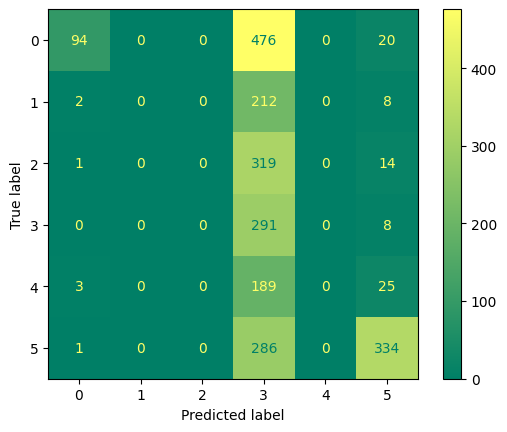

In [ ]:
#sgd
sgd = SGDClassifier(random_state=5)
sgd.fit(X_trainw2c, y_train)
y_pred = sgd.predict(X_testw2c)

print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap = 'summer')

## Word2Vec: pretrained embeddings

In [ ]:
# Show all available models in gensim-data
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [ ]:
w2vvectors =  gensim.downloader.load('word2vec-google-news-300')
textfast = gensim.downloader.load('fasttext-wiki-news-subwords-300')

In [ ]:
def vectorizew2c(sentence):
    words = sentence.split()
    words_vecs = [w2vvectors[word] for word in words if word in w2vvectors]
    if len(words_vecs) == 0:
        return np.zeros(300)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

def vectorizetextfast(sentence):
    words = sentence.split()
    words_vecs = [textfast[word] for word in words if word in textfast]
    if len(words_vecs) == 0:
        return np.zeros(300)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

In [ ]:
#word2vec

In [ ]:
X_trainvec = np.array([vectorizew2c(sentence) for sentence in X_train])
X_testvec = np.array([vectorizew2c(sentence) for sentence in X_test])

In [ ]:
model = xgb.XGBClassifier()
model.fit(X_trainvec, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

              precision    recall  f1-score   support

           0       0.80      0.86      0.83       590
           1       0.83      0.61      0.70       222
           2       0.86      0.76      0.81       334
           3       0.81      0.81      0.81       299
           4       0.57      0.46      0.51       217
           5       0.77      0.88      0.82       621

    accuracy                           0.78      2283
   macro avg       0.77      0.73      0.75      2283
weighted avg       0.78      0.78      0.78      2283



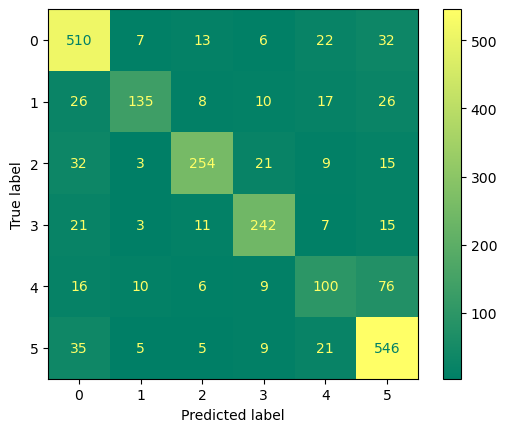

In [ ]:
y_pred = model.predict(X_testvec)
print(metrics.classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap = 'summer')

In [ ]:
#FastText

In [ ]:
X_traintext = np.array([vectorizetextfast(sentence) for sentence in X_train])
X_testtext = np.array([vectorizetextfast(sentence) for sentence in X_test])

              precision    recall  f1-score   support

           0       0.80      0.87      0.83       590
           1       0.88      0.70      0.78       222
           2       0.83      0.76      0.79       334
           3       0.83      0.78      0.81       299
           4       0.65      0.44      0.52       217
           5       0.77      0.92      0.84       621

    accuracy                           0.80      2283
   macro avg       0.79      0.74      0.76      2283
weighted avg       0.80      0.80      0.79      2283



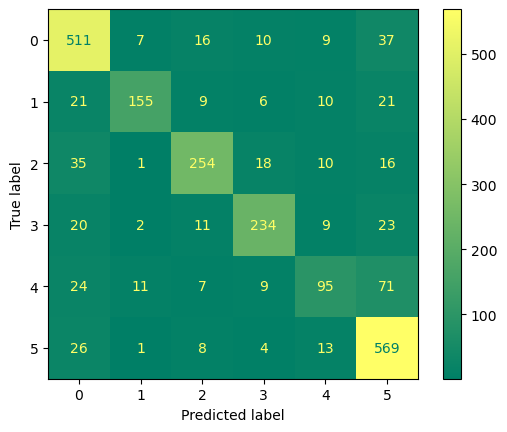

In [ ]:
model = xgb.XGBClassifier()
model.fit(X_traintext, y_train)
y_pred = model.predict(X_testtext)
print(metrics.classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap = 'summer')